In [183]:
# Read in the daily data from climate analyzer and calculate monthly averages from daily temps

import json
import random
import matplotlib.pyplot as plt
import datetime
import numpy as np
from IPython.display import Image, display

def get_month_name(day_of_year, year):
    # Create a datetime object for January 1st of the given year
    base_date = datetime.datetime(year, 1, 1)
    
    # Add the number of days to the base date to get the target date
    target_date = base_date + datetime.timedelta(days=day_of_year - 1)
    
    # Format the date as "{Month}"
    month_name = target_date.strftime("%B")
    
    return month_name

# calc future temperature variability rises from single reference points (observed daily temperatures)
def calc_monthly_averages_from_daily_data(cfsr_filepath):
    # Step 1: Load and parse the JSON file
    with open(cfsr_filepath) as file:
        data = json.load(file)

    # Step 2: Filter the data to include only four-digit years
    # Include only years from min_year on
    filtered_data = [entry for entry in data if len(entry['name']) == 4]

    # Step 3: Calculate month averages from daily data
    month_averages_for_each_year = {}
    start_year = 0
    for entry in filtered_data:
        year = int(entry['name'])
        month_total_temp = 0
        num_temps_counted_for_current_month = 0
        month_averages_for_each_year[year] = {}
        for i, temp in enumerate(entry['data']):
            # ignore null values (null place holders at the end of the data for non-leap years)
            day_number_1_indexed = i + 1
            month_name = get_month_name(day_number_1_indexed, year)
            is_last_day_of_month = (get_month_name(day_number_1_indexed + 1, year) != month_name)
            if temp:
                month_total_temp += temp
                num_temps_counted_for_current_month += 1
            if is_last_day_of_month and num_temps_counted_for_current_month > 0:
                month_averages_for_each_year[year][month_name] = month_total_temp / num_temps_counted_for_current_month
                # don't forget to reset for next month
                num_temps_counted_for_current_month = 0
                month_total_temp = 0
    print("CSFR Monthly averages from daily data:")
    print("  All time record in February 2016")
    print(f"    February 2016 (all time record): {month_averages_for_each_year[2016]['February']:6.3f}")
    print("  Month of interest:")
    try:
        print(f"    {month_of_interest} 2016: {month_averages_for_each_year[2016][month_of_interest]:6.3f}")
        print(f"    {month_of_interest} 2023: {month_averages_for_each_year[2023][month_of_interest]:6.3f}")
    except:
        print("---")
    return month_averages_for_each_year

In [184]:
import copy

def getData(gistemp_filepath, cfsr_filepath, extrapolate_year, threshold_year):
    month_averages_for_each_year = calc_monthly_averages_from_daily_data(cfsr_filepath)
    
    month_mapping = {
        "04": "January",
        "13": "February",
        "21": "March",
        "29": "April",
        "38": "May",
        "46": "June",
        "54": "July",
        "63": "August",
        "71": "September",
        "79": "October",
        "88": "November",
        "96": "December"
    }

    bulk_year_data = {}
    extrapolate_year_data = {}
    threshold_year_data = {}
    month_max_year = {}  # Variable to store the year for each month's maximum value
    prev_max_value = {}
    month_max_diff = {}  # Variable to store the maximum difference (GISTEMP - CFSR) for each month
    month_max_diff_year = {}  # Store the year for that max difference
    
    # for tracking differences over time
    all_diffs = {}
    
    with open(gistemp_filepath, "r") as file:
        next(file)  # Skip the first row
        next(file)  # Skip the second row
        for line in file:
            data = line.strip().split(",")
            year_month = data[0]
            year = int(year_month.split(".")[0])
            month_decimal = year_month.split(".")[1]
            month_name = month_mapping[month_decimal]
            temp_anomaly = float(data[2])

            if year < 2005:
                continue

            # Check if the current value is greater than the previous maximum for the corresponding month
            if month_name not in prev_max_value or temp_anomaly > prev_max_value[month_name]:
                prev_max_value[month_name] = temp_anomaly
                month_max_year[month_name] = year
            
            # Calculate the difference between the two temps (GISTEMP - monthly average for CFSR)
            # First check if we have data for that year, otherwise don't add to data
            if year in month_averages_for_each_year:
                # See 1999_Hansen_ha03200f.pdf, section 10. Data Products, about converting to absolute global mean
                offset_for_convert_from_change_to_absolute = 14
                temp_anomaly_difference_from_daily_average = temp_anomaly - month_averages_for_each_year[year][month_name] + offset_for_convert_from_change_to_absolute

                # for checking if there is a correlation for years
                if month_name not in all_diffs:
                    all_diffs[month_name] = {}
                all_diffs[month_name][year] = temp_anomaly_difference_from_daily_average
                
                # keep track of maximum difference between GISTEMP and CFSR for each month
                if month_name not in month_max_diff:
                    month_max_diff[month_name] = temp_anomaly_difference_from_daily_average
                    month_max_diff_year[month_name] = year
                else:
                    if month_max_diff[month_name] < temp_anomaly_difference_from_daily_average:
                        month_max_diff[month_name] = temp_anomaly_difference_from_daily_average
                        month_max_diff_year[month_name] = year
                
                # In this notebook calculating the differences between monthly GISTEMP global averages to
                #   monthly averages over daily data from climate_analyzer
                if year == extrapolate_year:
                    if month_name in extrapolate_year_data:
                        extrapolate_year_data[month_name].append(temp_anomaly_difference_from_daily_average)
                    else:
                        extrapolate_year_data[month_name] = [temp_anomaly_difference_from_daily_average]
                elif year == threshold_year:
                    if month_name in threshold_year_data:
                        threshold_year_data[month_name].append(temp_anomaly_difference_from_daily_average)
                    else:
                        threshold_year_data[month_name] = [temp_anomaly_difference_from_daily_average]
                else:
                    if month_name in bulk_year_data:
                        bulk_year_data[month_name].append(temp_anomaly_difference_from_daily_average)
                    else:
                        bulk_year_data[month_name] = [temp_anomaly_difference_from_daily_average]


    all_time_max_value = None
    # Print the anomaly maximum value for each year
    print("")
    print("Anomalies (GISTEMP):")
    for month_name, year in month_max_year.items():
        max_value = prev_max_value[month_name]
        if all_time_max_value == None:
            all_time_max_value = max_value
        if max_value > all_time_max_value:
            all_time_max_value = max_value
        month_str = month_name.ljust(10)
        print(f" Max value for {month_str} reached in {year}: {max_value:6.3f} C")
        
    # Combine all datasets into all_year_data
    all_year_data = copy.deepcopy(bulk_year_data)

    # Append threshold_year_data to all_year_data
    for month, temp_anomalies in threshold_year_data.items():
        all_year_data[month].extend(temp_anomalies)

    # Append extrapolate_year_data to all_year_data
    for month, temp_anomalies in extrapolate_year_data.items():
        all_year_data[month].extend(temp_anomalies)

    # Sort the data for each month in all_year_data
    for month, temp_anomalies in all_year_data.items():
        all_year_data[month] = sorted(temp_anomalies)
    
    month_averages_over_all_years = {}
    # not needed to print in bias corrected
    #print("Month, Avg. differences = GISTEMP - CFSR +14C, (max positive difference and year), (max pos. diff. - avg. diff.):")
    for month, temps in all_year_data.items():
        avg = np.average(temps)
        month_averages_over_all_years[month] = avg
        month_str = month.ljust(10)
        this_max_diff = month_max_diff[month]
        max_pos_from_avg = this_max_diff - avg
        max_pos_year = month_max_diff_year[month]
        # not needed to print in bias corrected
        # print(f" {month_str} : Avg: {avg:6.3f}, (MaxPos: {this_max_diff:6.3f} in {max_pos_year}), (MaxPos - Avg: {max_pos_from_avg:6.3f})")
    
    month = month_of_interest
    # GIS TEMP change from CFSR monthly and offset average for month of interest 2023
    # use month_averages_for_each_year to bias correct the differences
    gis_temp_change = month_averages_over_all_years[month] - 14 + month_averages_for_each_year[2023][month]
    print("")
    print(f"GIS TEMP anomaly projection ({month} 2023) (assuming 0 error): {gis_temp_change:6.3f}")
    # Month of interest, max error needed to tie record
    err_to_tie = all_time_max_value - gis_temp_change
    print(f"Error to tie ({month} 2023): {err_to_tie:6.3f}")
    # calc the distance from the average that (the error) needs to be for it to tie the record
    # this will be used in the difference plot
    dist_from_avg_to_tie = err_to_tie + month_averages_over_all_years[month]
    # not needed in bias corrected
    # print(f"Max Positive Error to tie record: {dist_from_avg_to_tie:6.3f}")
    
    # calculate percent of month of interest breaking record based on past errors...
    years_error_above = 0
    years_error_total = 0
    month_temps = all_year_data[month]
    for temp in month_temps:
        past_error_to_tie = temp - month_averages_over_all_years[month]
        years_error_total += 1
        if past_error_to_tie > err_to_tie:
            years_error_above += 1
    
    pct_above = 100.0 * years_error_above / years_error_total
    print(f"% of years for {month} that have error > than the error needed to tie for {month} 2023\n  (% chance of breaking anomaly record for {month}): {pct_above:2.2f} %")
    
    for [month_name, all_diffs_for_month_name] in all_diffs.items():
        # print graphs for each year        
        # Add a title to the chart
        all_diffs_for_current_month = list(all_diffs_for_month_name.values())
        years_for_current_month = list(all_diffs_for_month_name.keys())
        
        #fig, ax = plt.subplots(figsize=(8, 4))
        #ax.plot(years_for_current_month, all_diffs_for_current_month)
        #plt.title(f'{month_name} temp_anomaly_difference_from_daily_average')
        # Show the plot
        #plt.show()
    
    return bulk_year_data, extrapolate_year_data, threshold_year_data, month_averages_over_all_years, dist_from_avg_to_tie


In [185]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def graph_strip_plot(bulk_year_data, extrapolate_year_data, threshold_year_data, rise_threshold, month_averages_over_all_years, dist_from_avg_to_tie):
    fig, ax = plt.subplots(figsize=(8, 4))

    # Create a list of all data points and their corresponding labels
    data = []
    labels = []
    hue = []

    for month_name, temp_anomalies in bulk_year_data.items():
        data.extend(temp_anomalies - month_averages_over_all_years[month_name])
        labels.extend([month_name] * len(temp_anomalies))
        hue.extend(['All Other Years'] * len(temp_anomalies))

    for month_name, temp_anomalies in threshold_year_data.items():
        data.extend(temp_anomalies - month_averages_over_all_years[month_name])
        labels.extend([month_name] * len(temp_anomalies))
        hue.extend(['Threshold Year'] * len(temp_anomalies))

    for month_name, temp_anomalies in extrapolate_year_data.items():
        data.extend(temp_anomalies - month_averages_over_all_years[month_name])
        labels.extend([month_name] * len(temp_anomalies))
        hue.extend(['Extrapolate Year'] * len(temp_anomalies))

    # Set the style of the strip plot
    sns.stripplot(x=labels, y=data, hue=hue, dodge=True, alpha=0.9, palette=['#1f77b4', '#ff7f0e', '#ffdf00'], linewidth=0)

    # Set the y-axis label
    ax.set_ylabel('Error in difference between GISTEMP monthly\n anomalies and CFSR data (C) (bias corrected)')

    # Move the legend to the right of the chart
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.9))

    # Set the x-axis to be at the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Set more subticks on the y-axis
    plt.yticks(np.arange(-0.4, 0.5, 0.1))

    # Add faint horizontal grey lines for each y tick
    for y_tick in ax.get_yticks():
        ax.axhline(y=y_tick, color='gray', linestyle='dotted', alpha=0.5)
        
    # Increase spacing between each month
    plt.subplots_adjust(wspace=0.6)
    
    # Draw averages for each strip plot
    # Get the x-coordinates of each category by estimating
    x_coords = [(i + 1) / 12 for i in range(12)]
    
    # Graph the averages as horizontal lines for each month
    #i = 0
    #for month, month_avg in month_averages_over_all_years.items():
    #    plt.axhline(y=month_avg, color='green', linestyle='--', linewidth=1, label=f'Avg {month}', xmin=x_coords[i] - 0.08, xmax=x_coords[i])
    #    i += 1
    
    # Show what is necessary to tie the record for the month of interest
    err_threshold = dist_from_avg_to_tie - month_averages_over_all_years[month_of_interest]
    ax.axhline(y=err_threshold, linestyle='dashed', color='red')

    hline_y = err_threshold  # Replace with the desired y-coordinate of the horizontal line

    # Annotate the horizontal line with a label
    annotation_text = f'Error threshold in {month_of_interest}\n to tie all-time\n GISTEMP anomaly record'  # Replace with the desired annotation text
    ax.annotate(annotation_text, xy=(11.5, hline_y), xytext=(20, 12),
                textcoords='offset points', arrowprops=dict(arrowstyle='->'))

    
    # Add a title to the chart
    plt.title('Difference of Global Monthly Temperature Anomalies' + '\n' + 
              'Land + Ocean Temperature (GISTEMP)' + '\n' +
              'From Daily Data (CFSR) Averaged Monthly' + '\n' +
              '(Bias Corrected)'
             )

    
    # Show the plot
    plt.show()


In [186]:
def graph_temps(gistemp_filepath, cfsr_filepath, extrapolate_year, threshold_year, rise_threshold):
    bulk_year_data, extrapolate_year_data, threshold_year_data, month_averages_over_all_years, dist_from_avg_to_tie = getData(gistemp_filepath, cfsr_filepath, extrapolate_year, threshold_year)
    graph_strip_plot(bulk_year_data, extrapolate_year_data, threshold_year_data, rise_threshold, month_averages_over_all_years, dist_from_avg_to_tie)

In [187]:
#### CONFIG FOR MAIN PARAMETERS
# set for month of interest to analyze error for
month_of_interest = 'September'
# current year of missing months
extrapolate_year = 2023
# file path to CSV for Monthly Mean Global Surface Temperature
# from https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Monthly_Mean_Global_Surface_Temperature/graph.csv
# renamed from  graph.csv  to  global_temp_monthly_mean.csv
gistemp_filepath = 'global_temp_monthly_mean.csv'
# file path to local copy of json wih temp data
# from https://climatereanalyzer.org/clim/t2_daily/json/cfsr_world_t2_day.json
cfsr_filepath = 'cfsr_world_t2_day.json'
# threshold for new record monthly land+ocean temp anomaly (must exceed this value to be new anomaly record)
rise_threshold = 1.37
# year in which record was broken (year of the rise_threshold)
threshold_year = 2016


CSFR Monthly averages from daily data:
  All time record in February 2016
    February 2016 (all time record): 13.491
  Month of interest:
    September 2016: 15.955
    September 2023: 16.446

Anomalies (GISTEMP):
 Max value for January    reached in 2016:  1.170 C
 Max value for February   reached in 2016:  1.370 C
 Max value for March      reached in 2016:  1.360 C
 Max value for April      reached in 2020:  1.130 C
 Max value for May        reached in 2020:  1.020 C
 Max value for June       reached in 2023:  1.080 C
 Max value for July       reached in 2023:  1.190 C
 Max value for August     reached in 2023:  1.240 C
 Max value for September  reached in 2020:  0.990 C
 Max value for October    reached in 2015:  1.090 C
 Max value for November   reached in 2020:  1.100 C
 Max value for December   reached in 2015:  1.160 C

GIS TEMP anomaly projection (September 2023) (assuming 0 error):  1.423
Error to tie (September 2023): -0.053
% of years for September that have error > than th

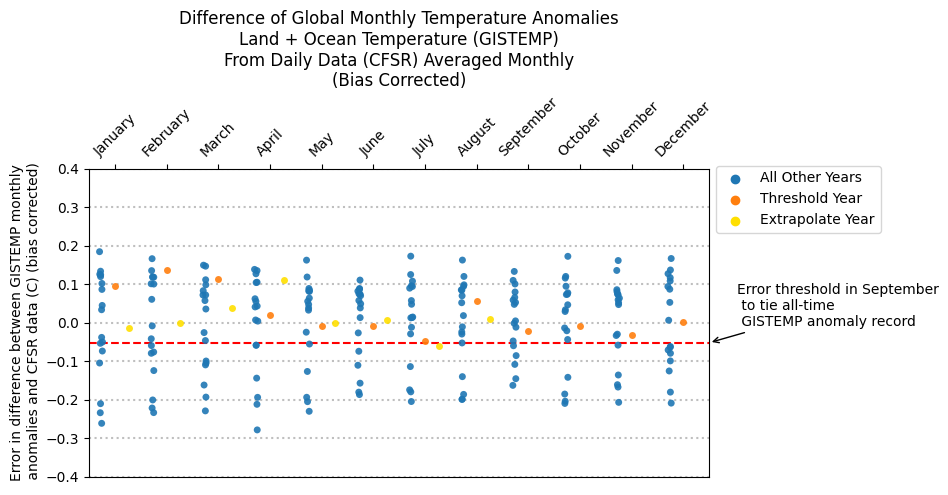

In [188]:
graph_temps(gistemp_filepath, cfsr_filepath, extrapolate_year, threshold_year, rise_threshold)

In [189]:
for month_of_interest in ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']:
    avgs2023 = calc_monthly_averages_from_daily_data(cfsr_filepath)



CSFR Monthly averages from daily data:
  All time record in February 2016
    February 2016 (all time record): 13.491
  Month of interest:
    January 2016: 13.083
    January 2023: 12.893
CSFR Monthly averages from daily data:
  All time record in February 2016
    February 2016 (all time record): 13.491
  Month of interest:
    February 2016: 13.491
    February 2023: 13.230
CSFR Monthly averages from daily data:
  All time record in February 2016
    February 2016 (all time record): 13.491
  Month of interest:
    March 2016: 14.114
    March 2023: 14.030
CSFR Monthly averages from daily data:
  All time record in February 2016
    February 2016 (all time record): 13.491
  Month of interest:
    April 2016: 14.966
    April 2023: 14.776
CSFR Monthly averages from daily data:
  All time record in February 2016
    February 2016 (all time record): 13.491
  Month of interest:
    May 2016: 15.779
    May 2023: 15.752
CSFR Monthly averages from daily data:
  All time record in February 

In [190]:
import numpy as np
cfsr_avg2016 = np.average(list(avgs2023[2016].values()))
print(f'Yearly average (CFSR) of monthly data for 2016 {cfsr_avg2016}')
cfsr_avg2023 = np.average(list(avgs2023[2023].values()))
print(f'Yearly average (CFSR) of monthly data for 2023 {cfsr_avg2023}')

Yearly average (CFSR) of monthly data for 2016 14.911139055740948
Yearly average (CFSR) of monthly data for 2023 15.301661298856462
